# 2. Forward Stepwise Regression for M-H adduct, negative mode

Number of rows after cleaning columns: 31
Number of columns after removing missing columns: 644


Performing Forward Stepwise Regression (R²):   0%| | 1/644 [00:00<03:29,  3.06it

Added Feature: nAcid, R²: 0.3688


Performing Forward Stepwise Regression (R²):   0%| | 2/644 [00:00<03:32,  3.02it

Added Feature: GATS3e, R²: 0.5517


Performing Forward Stepwise Regression (R²):   0%| | 3/644 [00:01<03:43,  2.87it

Added Feature: GATS7s, R²: 0.6476


Performing Forward Stepwise Regression (R²):   1%| | 4/644 [00:01<03:54,  2.73it

Added Feature: ATSC5i, R²: 0.7491


Performing Forward Stepwise Regression (R²):   1%| | 5/644 [00:01<04:06,  2.59it

Added Feature: VE1_Dt, R²: 0.7990


Performing Forward Stepwise Regression (R²):   1%| | 6/644 [00:02<04:20,  2.45it

Added Feature: AATSC8v, R²: 0.8500


Performing Forward Stepwise Regression (R²):   1%| | 7/644 [00:02<04:35,  2.31it

Added Feature: nAtomLAC, R²: 0.8790


Performing Forward Stepwise Regression (R²):   1%| | 8/644 [00:03<04:52,  2.17it

Added Feature: IC4, R²: 0.9103


Performing Forward Stepwise Regression (R²):   1%| | 9/644 [00:03<05:09,  2.05it

Added Feature: AATS5v, R²: 0.9409


Performing Forward Stepwise Regression (R²):   2%| | 10/644 [00:04<05:25,  1.95i

Added Feature: MATS7c, R²: 0.9488


Performing Forward Stepwise Regression (R²):   2%| | 11/644 [00:05<05:41,  1.85i

Added Feature: ATSC8p, R²: 0.9673


Performing Forward Stepwise Regression (R²):   2%| | 12/644 [00:05<05:58,  1.76i

Added Feature: VE2_D, R²: 0.9712


Performing Forward Stepwise Regression (R²):   2%| | 13/644 [00:06<06:13,  1.69i

Added Feature: nN, R²: 0.9760


Performing Forward Stepwise Regression (R²):   2%| | 13/644 [00:06<05:38,  1.86i


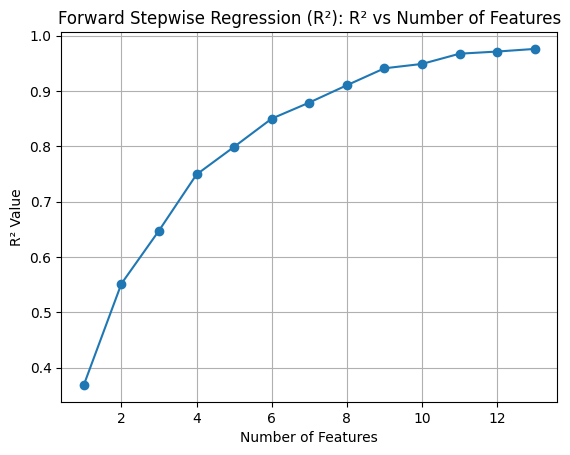

      Feature      Weight
0   Intercept  -46.058917
1       nAcid   -1.086211
2      GATS3e   31.770164
3      GATS7s   -1.633654
4      ATSC5i    0.139877
5      VE1_Dt   15.574613
6     AATSC8v   -4.572403
7    nAtomLAC   -0.566226
8         IC4   -6.559066
9      AATS5v    0.490039
10     MATS7c  -45.996982
11     ATSC8p    1.679689
12      VE2_D -288.725300
13         nN    0.371925


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Forward Stepwise Regression using R² for feature selection
def forward_selection_with_r2_threshold(X, y, r2_threshold=0.001):
    initial_features = []
    r2_values = []
    current_r2 = 0
    remaining_features = [col for col in X.columns if col not in initial_features]
    
    # Use tqdm to track progress
    with tqdm(total=len(remaining_features), desc="Performing Forward Stepwise Regression (R²)") as pbar:
        while True:
            remaining_features = [col for col in X.columns if col not in initial_features]
            new_r2 = pd.Series(index=remaining_features)
            for new_column in remaining_features:
                model = sm.OLS(y, sm.add_constant(X[initial_features + [new_column]])).fit()
                new_r2[new_column] = model.rsquared
            best_feature = new_r2.idxmax()
            best_r2 = new_r2.max()
            
            # Check if the improvement in R² is above the threshold
            if (best_r2 - current_r2) > r2_threshold:
                initial_features.append(best_feature)
                current_r2 = best_r2
                r2_values.append(current_r2)
                pbar.update(1)  # Update progress bar
                print(f"Added Feature: {best_feature}, R²: {current_r2:.4f}")
            else:
                break
    return initial_features, r2_values

# Load your dataset (replace 'your_file_path.xlsx' with the actual file path)
file_path = 'IE-training-file-standard.xlsx'
mh_sheet = pd.read_excel(file_path, sheet_name='M-H')

# Define the target variable (logRIE) and exclude unnecessary columns
exclude_columns = ['index', 'Molecule List', 'Molecule', 'SMILES', 'Adduct', 
                   'isotopic correction', 'Slope', 'RIE(LPE)', 'logRIE(LPE)']

# Select relevant features and target
X = mh_sheet.drop(columns=exclude_columns)  # Drop logRIE(LPE) from features
y = mh_sheet['logRIE(LPE)']  # Set logRIE(LPE) as the target

# Remove columns that have missing values (while keeping all rows)
X = X.dropna(axis=1)

# Ensure the number of rows in the dataset after cleaning columns
print(f"Number of rows after cleaning columns: {len(y)}")
print(f"Number of columns after removing missing columns: {X.shape[1]}")

# Perform Forward Stepwise Regression using R² with a threshold for improvement
selected_features_forward, r2_values_forward = forward_selection_with_r2_threshold(X, y, r2_threshold=0.001)

# Plot R² values against number of features
plt.plot(range(1, len(r2_values_forward) + 1), r2_values_forward, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('R² Value')
plt.title('Forward Stepwise Regression (R²): R² vs Number of Features')
plt.grid(True)
plt.show()

# Build the final model using the selected features
final_model = sm.OLS(y, sm.add_constant(X[selected_features_forward])).fit()

# Predict logRIE(LPE) values using the final model
y_pred = final_model.predict(sm.add_constant(X[selected_features_forward]))

# Extract the feature names and their corresponding coefficients (weights)
feature_weights = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features_forward,
    'Weight': final_model.params.values
})

# Define the output file path (you can specify your preferred file path)
output_file_path = 'selected_features_and_weights-M-H.xlsx'

# Export to Excel file
feature_weights.to_excel(output_file_path, index=False)

# Optionally, display the DataFrame with the features and their weights
print(feature_weights)


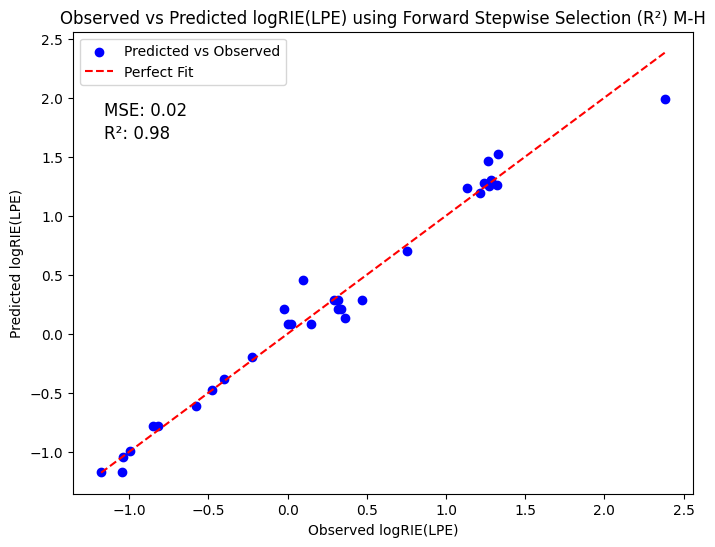

(['nAcid',
  'GATS3e',
  'GATS7s',
  'ATSC5i',
  'VE1_Dt',
  'AATSC8v',
  'nAtomLAC',
  'IC4',
  'AATS5v',
  'MATS7c',
  'ATSC8p',
  'VE2_D',
  'nN'],
 np.float64(0.9759545214110876))

In [5]:
# Plot observed vs predicted logRIE(LPE) for all rows
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')

# Add annotations for MSE and R²
mse_full_data = ((y - y_pred) ** 2).mean()
r2_full_data = final_model.rsquared
plt.text(0.05, 0.85, f'MSE: {mse_full_data:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.80, f'R²: {r2_full_data:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Labels and title
plt.xlabel('Observed logRIE(LPE)')
plt.ylabel('Predicted logRIE(LPE)')
plt.title('Observed vs Predicted logRIE(LPE) using Forward Stepwise Selection (R²) M-H')
plt.legend()
plt.show()


# Return selected features and R² value
selected_features_forward, r2_full_data